# Exploración con redes neuronales

## Importación de librerías y configuración de entorno

In [1]:
# Importamos librerias necesarias para realizar el analisis. 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

# Configuramos las opciones de pandas y seaborn para mejorar la visualización de datos.
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", color_codes=True)

## Carga y preparación del dataset

In [2]:
df = pd.read_csv('../data/raw/diabetes_012_health_indicators_BRFSS2015.csv')

Y = df['Diabetes_012']
X = df.drop(columns=["Diabetes_012"])

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=2, stratify=Y
)

## Conversión a tensores y creación de datasets

In [3]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)

X_test_tensor  = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor  = torch.tensor(Y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, Y_test_tensor)

## Sampler balanceado y DataLoaders

In [ ]:
class_counts = Y_train.value_counts().sort_index().values
num_classes = len(np.unique(Y_train))
N = len(Y_train)
class_weights = torch.tensor(N / (num_classes * class_counts), dtype=torch.float32)

'''
sample_weights = class_weights[Y_train_tensor]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
'''

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Definición del modelo MLP

In [5]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.2):
        super(Net, self).__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
hidden_dims = [128, 64, 32]
output_dim = num_classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net(input_dim, hidden_dims, output_dim).to(device)

## Función de pérdida y optimizador

In [6]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

## Funciones de entrenamiento y evaluación

In [7]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total_samples += Xb.size(0)

    return total_loss / total_samples, total_correct / total_samples

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())
    return np.array(all_labels), np.array(all_preds)

## Entrenamiento del modelo y cálculo de métricas clave

In [8]:
epochs = 40
best_macro_f1 = -np.inf

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    y_true, y_pred = evaluate(model, test_loader, device)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Acc: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    if f1 > best_macro_f1:
        best_macro_f1 = f1
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        print(">> Nuevo mejor modelo (macro F1).")

model.load_state_dict(best_state)

Epoch 01 | Train Loss: 0.9930 | Train Acc: 0.6561 | Test Acc: 0.7031 | Precision: 0.4107 | Recall: 0.4918 | F1: 0.4104
>> Nuevo mejor modelo (macro F1).
Epoch 02 | Train Loss: 0.9615 | Train Acc: 0.6897 | Test Acc: 0.7030 | Precision: 0.4119 | Recall: 0.4948 | F1: 0.4113
>> Nuevo mejor modelo (macro F1).
Epoch 03 | Train Loss: 0.9567 | Train Acc: 0.6953 | Test Acc: 0.7067 | Precision: 0.4132 | Recall: 0.4967 | F1: 0.4135
>> Nuevo mejor modelo (macro F1).
Epoch 04 | Train Loss: 0.9524 | Train Acc: 0.6974 | Test Acc: 0.7099 | Precision: 0.4343 | Recall: 0.4965 | F1: 0.4155
>> Nuevo mejor modelo (macro F1).
Epoch 05 | Train Loss: 0.9500 | Train Acc: 0.6980 | Test Acc: 0.7188 | Precision: 0.4145 | Recall: 0.4957 | F1: 0.4184
>> Nuevo mejor modelo (macro F1).
Epoch 06 | Train Loss: 0.9487 | Train Acc: 0.6990 | Test Acc: 0.7109 | Precision: 0.4143 | Recall: 0.4970 | F1: 0.4158
Epoch 07 | Train Loss: 0.9474 | Train Acc: 0.6926 | Test Acc: 0.7064 | Precision: 0.4294 | Recall: 0.5034 | F1: 0.42

<All keys matched successfully>

## Evaluación final del modelo

              precision    recall  f1-score   support

           0     0.9420    0.7244    0.8190     42741
           1     0.0383    0.0648    0.0481       926
           2     0.3201    0.7380    0.4465      7069

    accuracy                         0.7143     50736
   macro avg     0.4335    0.5091    0.4379     50736
weighted avg     0.8389    0.7143    0.7530     50736



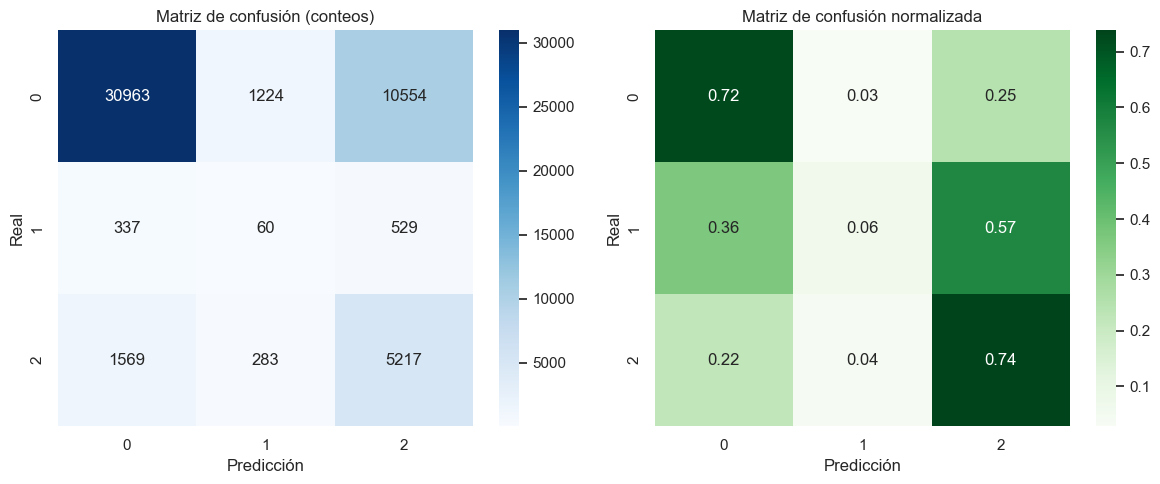

Macro F1: 0.4379 | Weighted F1: 0.7530


In [9]:
y_true, y_pred = evaluate(model, test_loader, device)

print(classification_report(y_true, y_pred, digits=4, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true') 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true), ax=axes[0])
axes[0].set_title("Matriz de confusión (conteos)")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Real")

sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true), ax=axes[1])
axes[1].set_title("Matriz de confusión normalizada")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()

macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
print(f"Macro F1: {macro_f1:.4f} | Weighted F1: {weighted_f1:.4f}")